In [1]:
# needed for evaluation metric
!pip install munkres

In [2]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from scipy.stats import pearsonr as corr
import pickle
from tqdm import tqdm
import sys
from munkres import Munkres
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import gennorm
from typing import Union

from scipy.fft import dct

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using {device}")

using cpu


In [3]:
# parameters
N = 16  # number of sparse sources
K = 3  # number of active components
M = 8  # number of measurements
seed = 20240625
num_data = 1024
lr = 3e-3
num_step = 20000
weight = 1e-2

In [4]:
def bound(N, K):
    return K * np.log10(N / K)

print('minimum M to solve problem', bound(N, K))

minimum M to solve problem 2.180996183808787


In [6]:
# helper
def sample_codes(S, S_):
    np.random.seed(seed)
    ind = np.random.choice(num_data, 9, replace=False)
    for j, i in enumerate(ind):
        plt.subplot(3, 3, j + 1)
        plt.plot(S[i], '.-')
        plt.plot(S_[i], '.-')
        plt.legend(['true', 'pred'])
    plt.tight_layout()
    plt.show()


def show_correlations(S, S_):
    plt.figure(figsize=(8, 8))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.scatter(S[:, i], S_[:, i], s=3)
        plt.grid()
        plt.title('c=%.4f' % corr(S[:, i], S_[:, i])[0])
        plt.xlabel('true')
        plt.ylabel('learned')
    plt.tight_layout()
    plt.show()


def find_permutation(S, S_):
    matches, indexes = match_latents(S, S_)
    S__ = np.zeros_like(S_)
    for i in range(N):
        S__[:, i] = S_[:, indexes[i][1]].copy()
    return S__


def sample_signal():
    s = np.random.normal(0, 1, N)
    s = np.abs(s)
    ind = np.random.choice(N, K, replace=False)
    mask = np.zeros(N)
    mask[ind] = 1
    s *= mask
    return s


def analyze(S, S_):
    # permute
    plt.imshow(match_latents(S, S_)[0])
    plt.colorbar()
    plt.xlabel('true')
    plt.ylabel('learned')
    plt.title('As Learned')
    plt.show()
    S_ = find_permutation(S, S_)
    plt.imshow(match_latents(S, S_)[0])
    plt.colorbar()
    plt.xlabel('true')
    plt.ylabel('learned')
    plt.title('Optimal Permutation')
    plt.show()
    # analyze
    sample_codes(S, S_)
    show_correlations(S, S_)


def criterion(S_, X, X_, weight=weight):
    loss = torch.sum((X - X_) ** 2) + weight * torch.sum(torch.abs(S_))
    return loss


# Evaluation metric
munk = Munkres()
def match_latents(z, z_):
    matches = np.zeros((z.shape[1], z_.shape[1]))
    for i in range(z.shape[1]):
        for j in range(z_.shape[1]):
            matches[i, j] = abs(corr(z[:, i], z_[:, j])[0])
    matches[np.isnan(matches)] = 0
    indexes = munk.compute(-matches)
    return matches, indexes


def eval_nd(z, z_):
    matches, indexes = match_latents(z, z_)
    corrs = []
    for i in indexes:
        corrs.append(matches[i[0], i[1]])
    return corrs


def mcc(z, z_):
    return np.mean(eval_nd(z, z_)[0])

In [7]:
class SparseCoding(nn.Module):
    def __init__(self, S, D, learn_D, seed=seed):
        super().__init__()
        self.learn_D = learn_D
        torch.manual_seed(seed + 42)
        self.log_S_ = nn.Parameter(data=-10 * torch.ones(S.shape), requires_grad=True)
        if learn_D:
            self.D_ = nn.Parameter(data=torch.randn(D.shape), requires_grad=True)
        else:
            self.D_ = nn.Parameter(data=D, requires_grad=False)

    def forward(self, X=None):
        if self.learn_D:
            self.D_.data /= torch.linalg.norm(self.D_, dim=1, keepdim=True)
        S_ = torch.exp(self.log_S_)
        X_ = S_ @ self.D_
        return S_, X_


class Exp(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, X):
        return torch.exp(X)


class SparseAutoEncoder(nn.Module):
    def __init__(self, D, learn_D, seed=seed, relu=True):
        super().__init__()
        self.learn_D = learn_D
        torch.manual_seed(seed + 42)
        if relu:
            self.encoder = nn.Sequential(nn.Linear(M, N), nn.ReLU())
        else:
            self.encoder = nn.Sequential(nn.Linear(M, N), Exp())
        if learn_D:
            self.D_ = nn.Parameter(data=torch.randn(D.shape), requires_grad=True)
        else:
            self.D_ = nn.Parameter(data=D, requires_grad=False)

    def forward(self, X):
        if self.learn_D:
            self.D_.data /= torch.linalg.norm(self.D_, dim=1, keepdim=True)
        S_ = self.encoder(X)
        X_ = S_ @ self.D_
        return S_, X_


def train(model):
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    for i in range(num_step):
        S_, X_ = model.forward(X)
        loss = criterion(S_, X, X_, weight=weight)
        optim.zero_grad()
        loss.backward()
        optim.step()
        if i > 0 and not i % 1000:
            if not torch.all(S_.var(0) > 0):
                print('dead latents')
            print('step', i, 'loss', loss.item(),
                  'MCC', mcc(S, S_.detach().cpu().numpy()))
    S_ = S_.detach().cpu().numpy()
    print('final MCC', mcc(S, S_))
    return S_

In [8]:
# generate sample and move to torch
S = []
np.random.seed(seed)
for i in range(num_data):
    S.append(sample_signal())
S = np.array(S)
torch.manual_seed(seed)
D = torch.randn(N, M, dtype=torch.float32).to(device)
D /= torch.linalg.norm(D, dim=1, keepdim=True)
X = torch.tensor(S, dtype=torch.float32).to(device) @ D
print(S.shape, X.shape, D.shape)

(1024, 16) torch.Size([1024, 8]) torch.Size([16, 8])


## Sparse code, known dictionary

step 1000 loss 2900.756103515625 MCC 0.2709949630045932
step 2000 loss 61.13169860839844 MCC 0.9038211129483644
step 3000 loss 36.01313400268555 MCC 0.9431548154377039
step 4000 loss 30.0601749420166 MCC 0.967098687383703
step 5000 loss 27.880935668945312 MCC 0.9799465044189988
step 6000 loss 26.688627243041992 MCC 0.986304198905502
step 7000 loss 25.955350875854492 MCC 0.9904184753204498
step 8000 loss 25.487642288208008 MCC 0.9936898915218869
step 9000 loss 25.17985725402832 MCC 0.9955541441900266
step 10000 loss 24.97623634338379 MCC 0.9975909911204857
step 11000 loss 24.851062774658203 MCC 0.9979424558777883
step 12000 loss 24.772541046142578 MCC 0.9980861737916973
step 13000 loss 24.724056243896484 MCC 0.9981836348536515
step 14000 loss 24.69402313232422 MCC 0.9982227614996056
step 15000 loss 24.67557144165039 MCC 0.9982328540922055
step 16000 loss 24.664533615112305 MCC 0.9982360821241414
step 17000 loss 24.65772819519043 MCC 0.9982368611547603
step 18000 loss 24.65350341796875 M

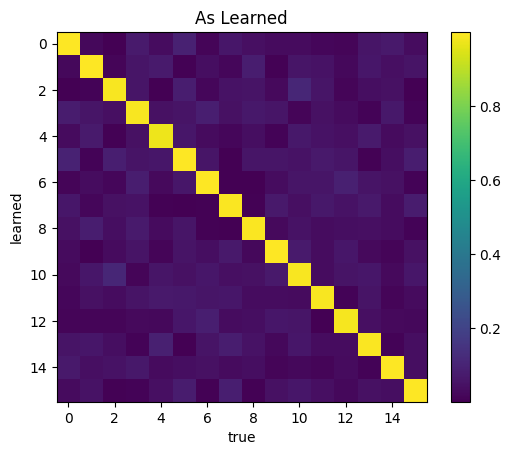

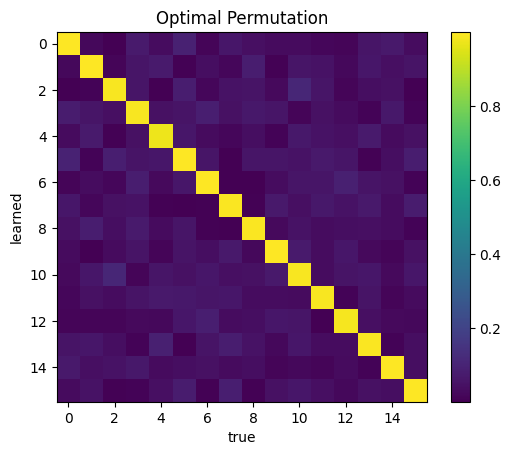

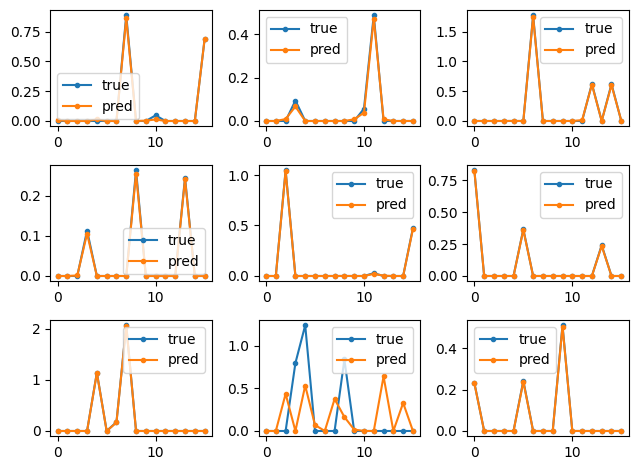

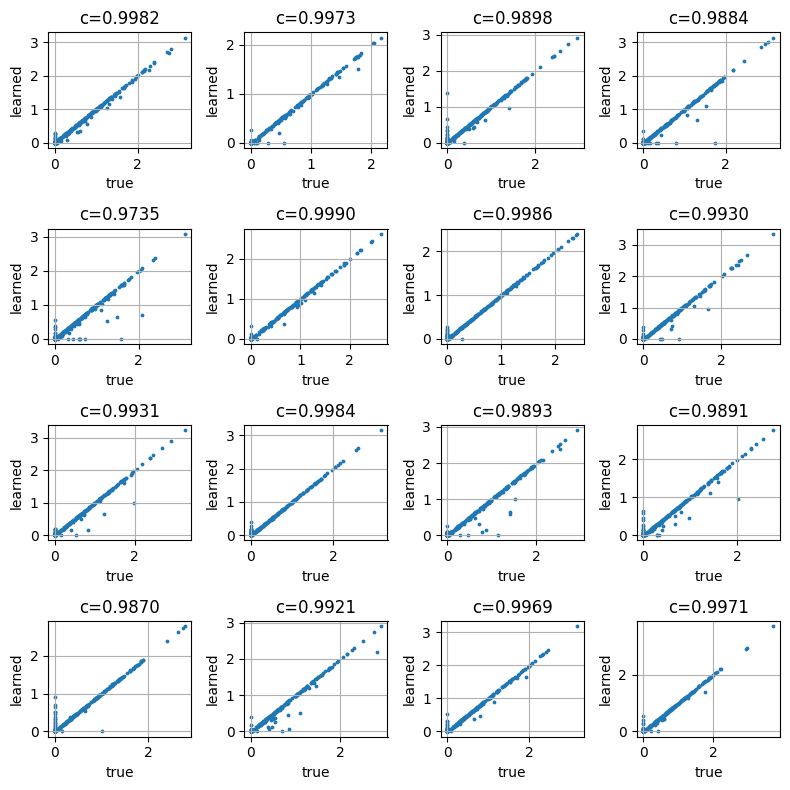

In [9]:
sc0 = SparseCoding(S, D, learn_D=False, seed=seed).to(device)
S_ = train(sc0)
analyze(S, S_)

## Sparse autoencoder, known dictionary

step 1000 loss 518.9008178710938 MCC 0.7906882673758802
step 2000 loss 348.8263244628906 MCC 0.7544011369482638
step 3000 loss 300.436279296875 MCC 0.7435712286861775
step 4000 loss 285.82745361328125 MCC 0.7416518321736685
step 5000 loss 280.7118835449219 MCC 0.7419762179700176
step 6000 loss 278.61767578125 MCC 0.7484308652536249
step 7000 loss 277.63446044921875 MCC 0.7566435856842879
step 8000 loss 277.21832275390625 MCC 0.7617058495273117
step 9000 loss 277.0627746582031 MCC 0.7641267763813651
step 10000 loss 277.0101318359375 MCC 0.7649648151769433
step 11000 loss 276.994384765625 MCC 0.7650465213999009
step 12000 loss 276.9916076660156 MCC 0.7650211595458536
step 13000 loss 276.991455078125 MCC 0.7650227903330336
step 14000 loss 276.9942932128906 MCC 0.7648858406482133
step 15000 loss 276.9913024902344 MCC 0.7649668429873004
step 16000 loss 276.9912414550781 MCC 0.7649685361503601
step 17000 loss 276.9913024902344 MCC 0.7649570277630555
step 18000 loss 276.99127197265625 MCC 0.7

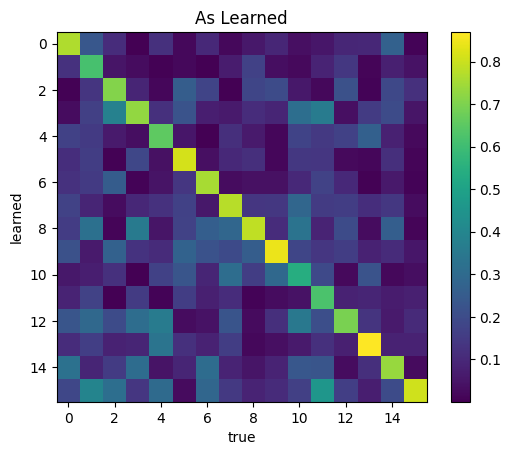

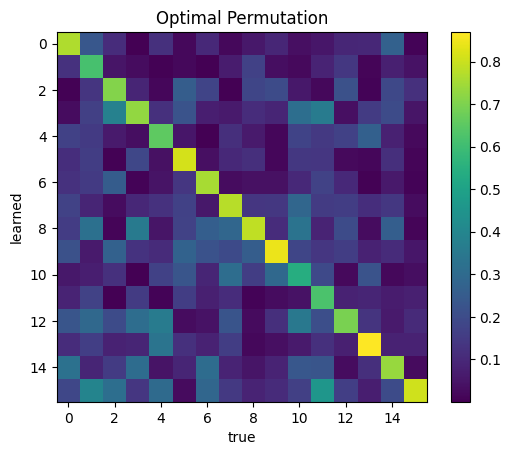

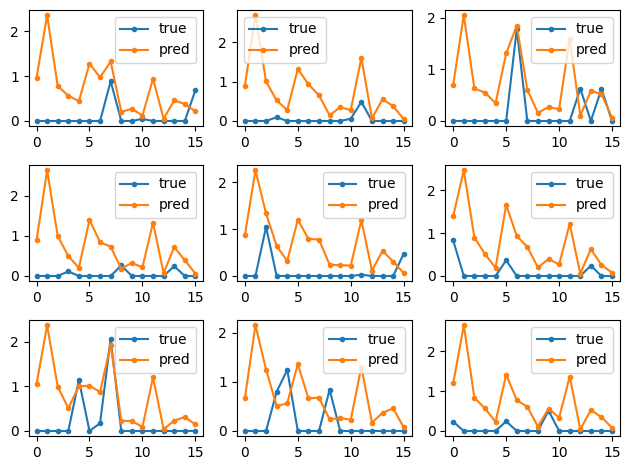

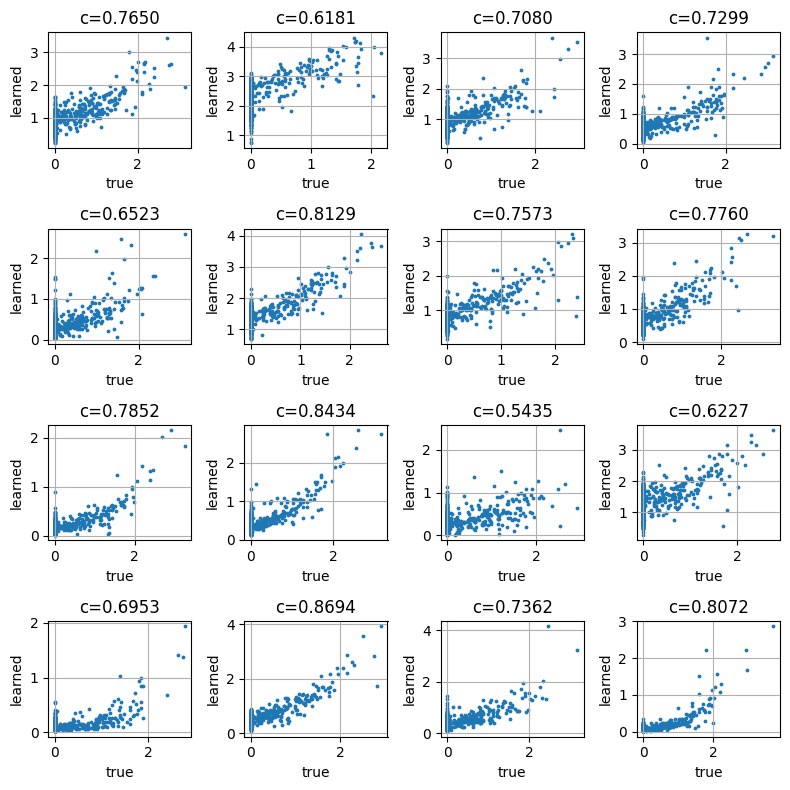

In [10]:
sae0 = SparseAutoEncoder(D, learn_D=False, seed=seed, relu=False).to(device)
S_ = train(sae0)
analyze(S, S_)

## Sparse coding, learning dictionary

step 1000 loss 2802.861328125 MCC 0.44692627353612313
step 2000 loss 190.0848388671875 MCC 0.7884879163620739
step 3000 loss 56.455055236816406 MCC 0.6840620576752856
step 4000 loss 40.4018669128418 MCC 0.7022185752485519
step 5000 loss 36.01589584350586 MCC 0.7603060655991399
step 6000 loss 33.72260665893555 MCC 0.8332903717294531
step 7000 loss 32.406097412109375 MCC 0.8782570703123871
step 8000 loss 31.444454193115234 MCC 0.9044704600663258
step 9000 loss 30.432964324951172 MCC 0.9106566462727823
step 10000 loss 29.928281784057617 MCC 0.9127237258016507
step 11000 loss 29.95750617980957 MCC 0.9064039285620016
step 12000 loss 30.395172119140625 MCC 0.9023476455992463
step 13000 loss 30.903287887573242 MCC 0.8827967783977304
step 14000 loss 31.8712100982666 MCC 0.7596269763283523
step 15000 loss 32.76664733886719 MCC 0.7432163460339449
step 16000 loss 32.20016860961914 MCC 0.7875955303226061
step 17000 loss 32.16244888305664 MCC 0.812685163272941
step 18000 loss 32.426448822021484 MCC

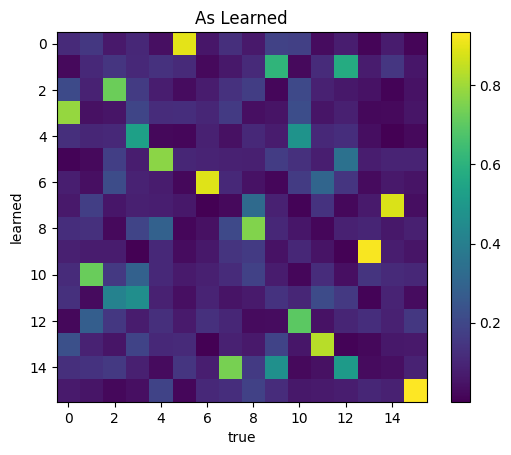

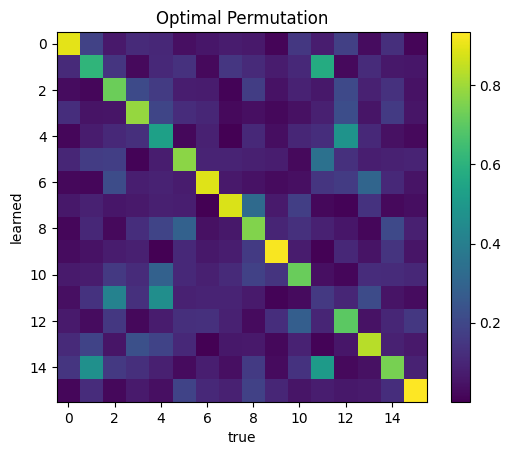

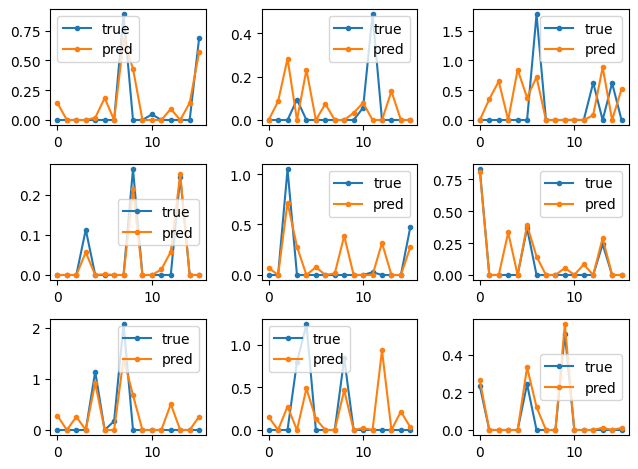

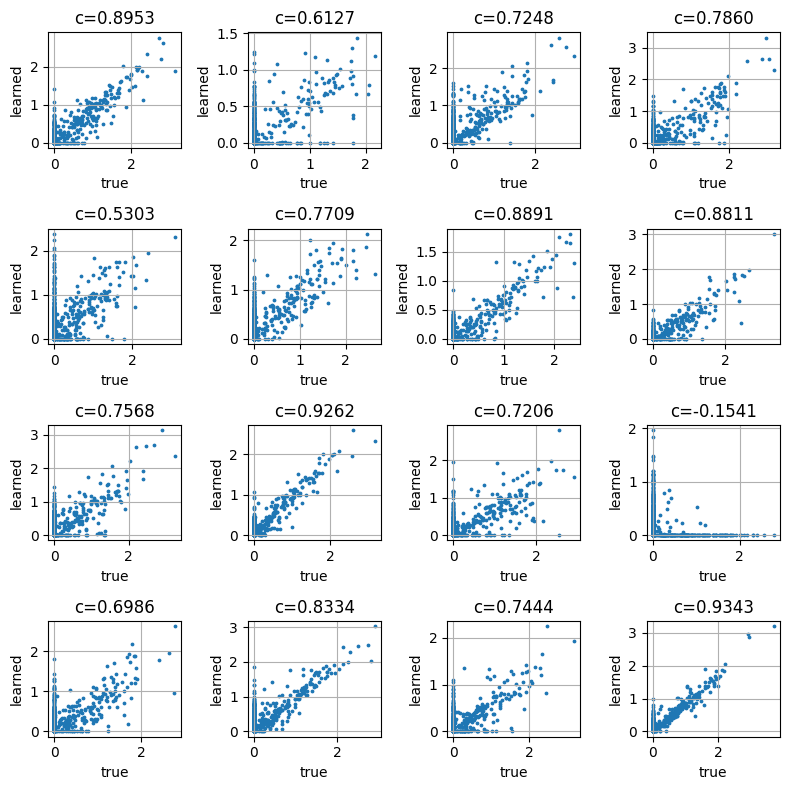

In [13]:
sc1 = SparseCoding(S, D, learn_D=True, seed=seed).to(device)
S_ = train(sc1)
analyze(S, S_)

## Sparse autoencoder, learning dictionary

step 1000 loss 200.42056274414062 MCC 0.6858140732629139
step 2000 loss 167.4375 MCC 0.4816326853872106
step 3000 loss 144.28041076660156 MCC 0.5015268901649161
step 4000 loss 128.1123504638672 MCC 0.7268936561425091
step 5000 loss 117.89173889160156 MCC 0.7369586328671494
step 6000 loss 115.10596466064453 MCC 0.7181525309140797
step 7000 loss 112.9382553100586 MCC 0.691669537175608
step 8000 loss 110.4206314086914 MCC 0.6166290908382845
step 9000 loss 109.93016052246094 MCC 0.4805933443788991
step 10000 loss 109.6013412475586 MCC 0.5908615060556821
step 11000 loss 109.79910278320312 MCC 0.4358979459926098
step 12000 loss 109.2861328125 MCC 0.403952798368286
step 13000 loss 107.87928771972656 MCC 0.4653050277207602
step 14000 loss 110.75048065185547 MCC 0.3862787428215929
step 15000 loss 111.33917999267578 MCC 0.4784845870254233
step 16000 loss 109.50566864013672 MCC 0.43208267463424554
step 17000 loss 109.45870971679688 MCC 0.43096285110452026
step 18000 loss 111.23261260986328 MCC 0.

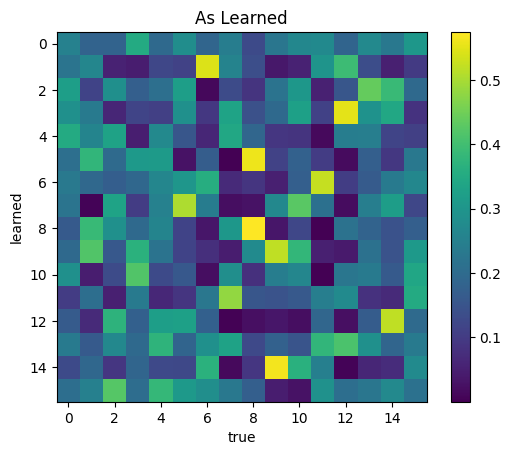

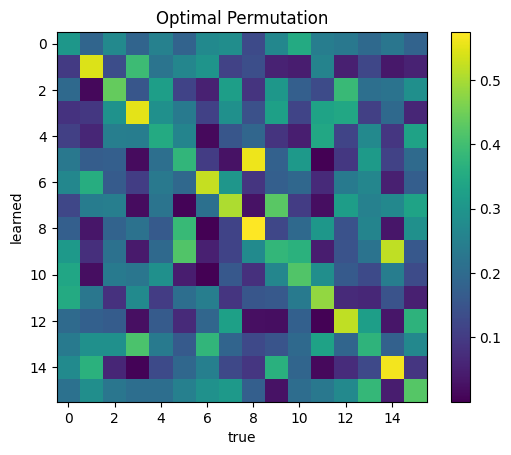

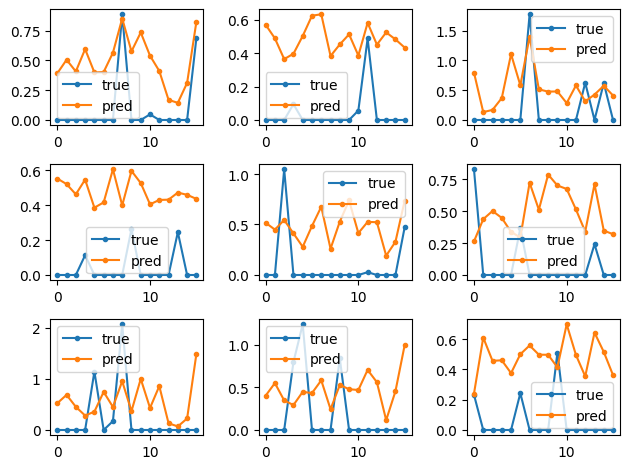

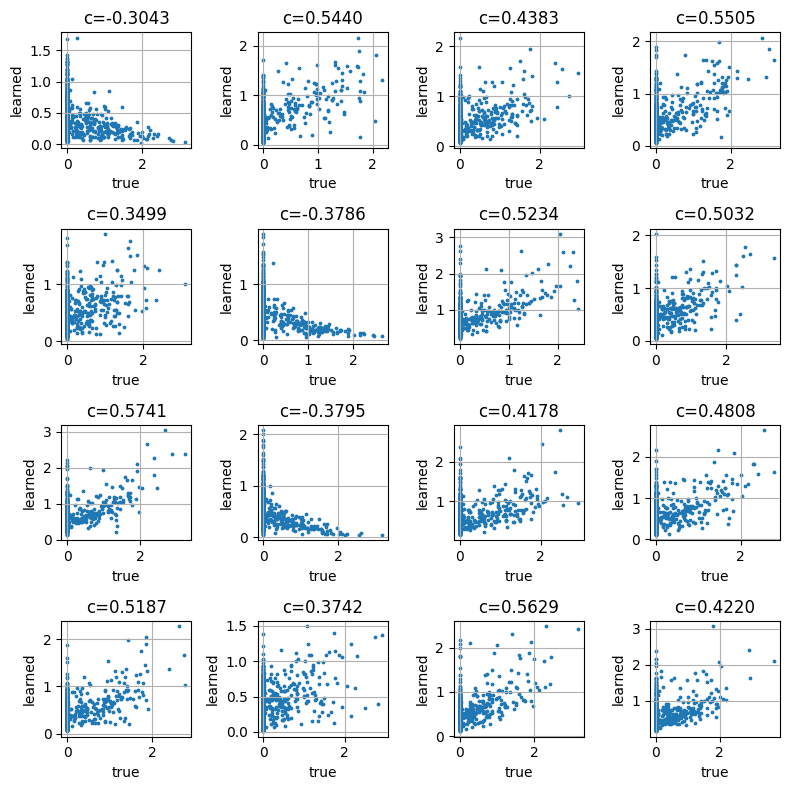

In [12]:
sae1 = SparseAutoEncoder(D, learn_D=True, seed=seed, relu=False,).to(device)
S_ = train(sae1)
analyze(S, S_)